# Make recommendations to the general managers of 10 hotels based on the user review

## Out line of the problem
- ### Based on 26,000 happy reviews and 12,000 not-happy reviews of 10 hotels, identify topics in these reviews and give a score to each hotel for each topic. Use these scores to make a recommendations to each hotel's general manager.

## Approach

- ### Pre-process the review text
    - remove unwanted characters, numbers, and symbols.
    - remove "stop words" as defined in nltk (english stop words) + "hotel" and "room" (common words in this review that add no information.
    - remove short words (len <3)
    - make all lower case

- ### Tokenize and then lemmatize using spacy library
    - choose only nouns and adjectives

- ### Create latent Dirichlet allocation (LDA) model using gensim library to identify topics in the reviews
    - create a term dictionary of the corpus 
    - use the dictionary to conver the reviews into a document term matrix
    - use the matrix to create LDA model

- ### Visually check the topics

- ### Score each review for a topic
    - give plus points for happy review in that topic
    - give minus points for not-happy review in that topic
    - add points for each hotel
    
- ### Review the score and provide recommendation

## Summary

- ### For all hotels, the review from the customers are complaining about two topics: 1) a topic that is characterized by keywords: location, staff, and price and 2) a topic that is characterized by keywords: front, desk, service, and staff.

- ### General Managers at all hotels should try to improve customer service at the front desk and staff's service towards the guests because these are the most frequent complaints.

- ### For all hotels, the happy reviews are talking about topics that are characterized by keywords: front, desk, free, breakfast, staff, location, and clean.

- ### General Managers should continue to improve in these categories by improving the quality of customer service at the font desk, provide free breakfast, keep the location clean, and improve the service by their staff.

### Import packages, download some data

In [1]:
import os
import nltk
from nltk import FreqDist
#nltk.download('stopwords')
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

from nltk.corpus import stopwords

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read the data (happy reviews and not-happy reviews, together with hotel ID)

In [2]:
#Read the excel file that contains the review and hotel ID
current_path = os.getcwd()
file = '/datasets/HappyHotel/hotel_happy_reviews.xlsx'
happy_reviews = pd.read_excel(current_path + file)

In [3]:
happy_reviews.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10329,"Stayed here with husband and sons on the way to an Alaska Cruise. We all loved the hotel, great experience. Ask for a room on the North tower, facing north west for the best views. We had a high f...",happy,8
1,id10331,We had - rooms. One was very nice and clearly had been updated more recently than the other. The other was clean and the bed was comfy but it needed some updating (carpet was old and wrinkled for ...,happy,3
2,id10333,"My wife & I stayed in this glorious city a while back. SF is expensive, but we found this little hotel in a super location for a very reasonable price. By no means is it a --star hotel, but the ro...",happy,3
3,id10334,My boyfriend and I stayed at the Fairmont on a recent trip to San Francisco. I could not recommend this hotel more. \nI called the hotel a few weeks before to order a cake to be delivered to our r...,happy,7
4,id10336,"Steps off Times Square, nice rooms, stayed - nights, great for a short visit.",happy,3


In [4]:
file2 = '/datasets/HappyHotel/hotel_not_happy_reviews.xlsx'
not_happy_reviews = pd.read_excel(current_path + file2)

In [5]:
not_happy_reviews.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10326,The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok for a overnight stay if you're not too fussy. Would consider staying again if the price was right. Br...,not happy,3
1,id10327,"I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little o...",not happy,9
2,id10328,"I booked this hotel through Hotwire at the lowest price I could find. When we got there the front desk manager gave us a """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""smoking"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" roo...",not happy,3
3,id10330,"My girlfriends and I stayed here to celebrate our --th birthdays. We had planned this weekend getaway back in February, so we were all looking forward to it. There was - of us so we rented - ajoin...",not happy,3
4,id10332,"My husband and I have stayed in this hotel a few times. Though not the fanciest hotel, we love the fact that we can walk the - or so miles to Fenway. It is clean and the staff is very accomodating...",not happy,7


### Define a function to plot the most frequent terms in the review. Use this to check how the frequent terms change as we remove symbols, numbers, "stop words", etc

In [6]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.xticks(rotation = 90)
  sns.despine()
  plt.show()

### Check the frequency of the words in happy and not-happy reviews, before any preprocessing

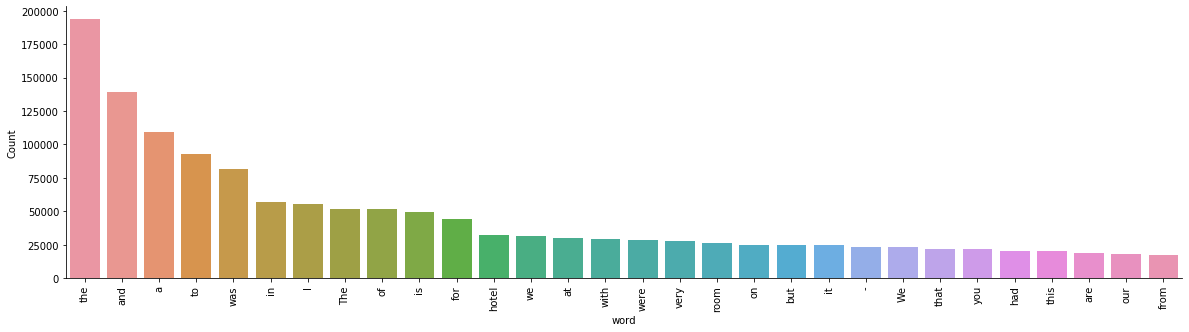

In [7]:
freq_words(happy_reviews['Description'])

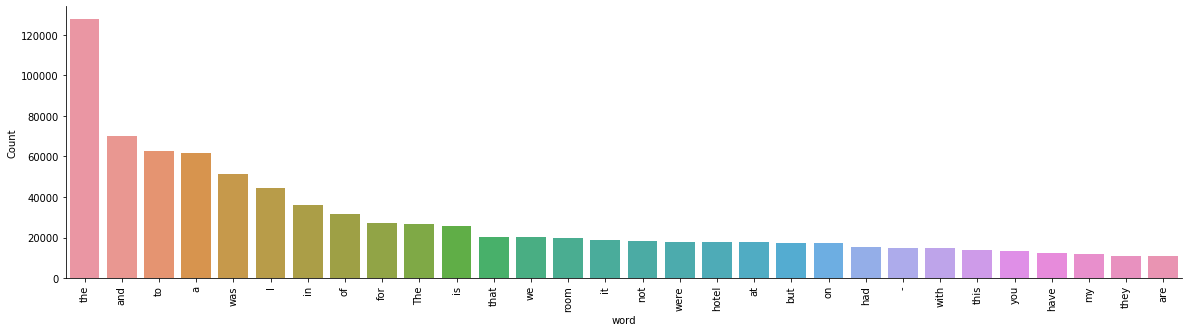

In [8]:
freq_words(not_happy_reviews['Description'])

### Remove unwanted characters, numbers, symbols, stop words (defined by nltk + manually add "hotel" and "room" ), and short words (length <3 )

In [9]:
# remove unwanted characters, numbers and symbols
happy_reviews['Description'] = happy_reviews['Description'].str.replace("[^a-zA-Z#]", " ")
not_happy_reviews['Description']=not_happy_reviews['Description'].str.replace("[^a-zA-Z#]", " ")

In [45]:
#remove stop words and short words.
stop_words = stopwords.words('english')

#Remove "hotel" and "room" because they show up very often (from preliminary analysis) and not informative
stop_words.extend(['hotel','room','rooms'])

# function to remove stopwords
def remove_stopwords(description):
    description_new = " ".join([i for i in description if i not in stop_words])
    return description_new

# remove short words (length < 3)
happy_reviews['Description'] = happy_reviews['Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
not_happy_reviews['Description'] = not_happy_reviews['Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
happy_description = [remove_stopwords(r.split()) for r in happy_reviews['Description']]
not_happy_description = [remove_stopwords(r.split()) for r in not_happy_reviews['Description']]

# make entire text lowercase
happy_description = [r.lower() for r in happy_description]
not_happy_description = [r.lower() for r in not_happy_description]

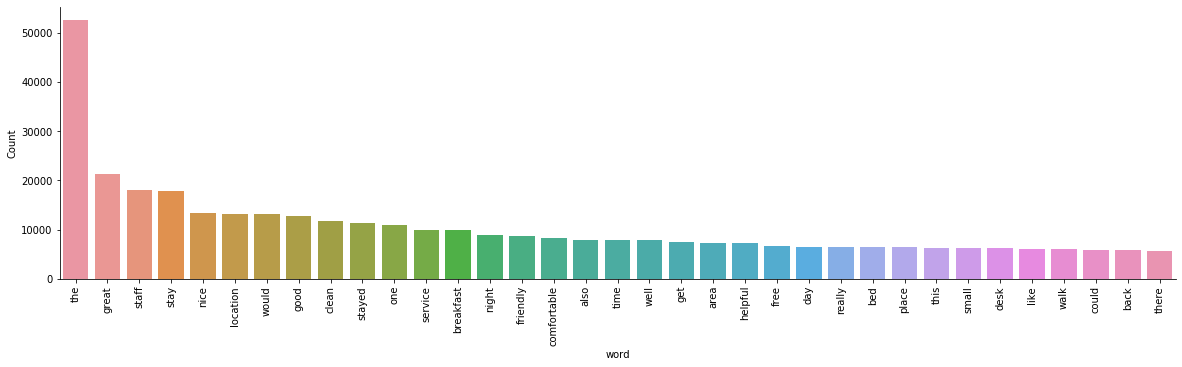

In [46]:
freq_words(happy_description, 35)

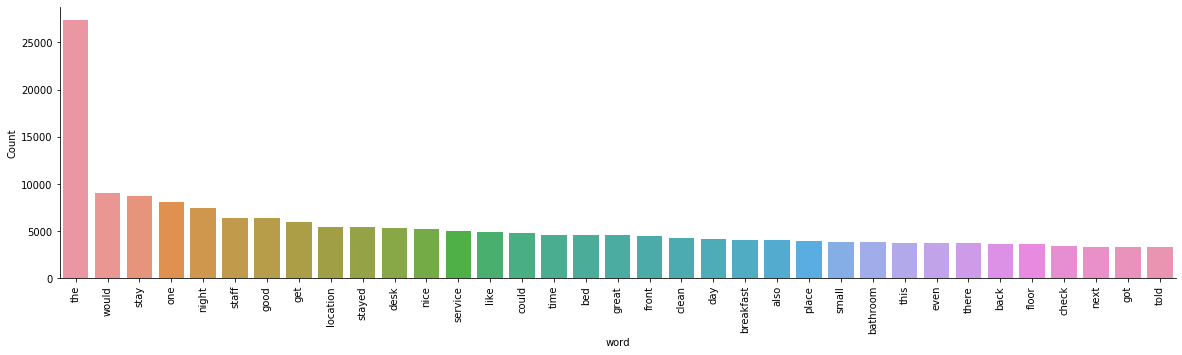

In [47]:
freq_words(not_happy_description,35)

In [48]:
#!python -m spacy download en # one time run

### Use spacy library to lemmatize. Chose only the nouns and adjectives

In [49]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

### Tokenize and then lemmatize

In [50]:
happy_description_tokenized = pd.Series(happy_description).apply(lambda x: x.split())
print(happy_description_tokenized[0])

['stayed', 'husband', 'sons', 'way', 'alaska', 'cruise', 'loved', 'great', 'experience', 'ask', 'north', 'tower', 'facing', 'north', 'west', 'best', 'views', 'high', 'floor', 'stunning', 'view', 'needle', 'city', 'even', 'cruise', 'ships', 'ordered', 'service', 'dinner', 'could', 'enjoy', 'perfect', 'views', 'room', 'service', 'dinners', 'delicious', 'you', 'perfect', 'spot', 'walk', 'everywhere', 'enjoy', 'city', 'almost', 'forgot', 'heavenly', 'beds', 'heavenly']


In [51]:
not_happy_description_tokenized = pd.Series(not_happy_description).apply(lambda x: x.split())
print(not_happy_description_tokenized[0])

['the', 'kind', 'clean', 'very', 'strong', 'smell', 'dogs', 'generally', 'average', 'overnight', 'stay', 'fussy', 'would', 'consider', 'staying', 'price', 'right', 'breakfast', 'free', 'better', 'nothing']


In [52]:
happy_description_lemmatized = lemmatization(happy_description_tokenized)
print(happy_description_lemmatized[0]) # print lemmatized review

['great', 'experience', 'good', 'view', 'high', 'floor', 'stunning', 'city', 'cruise', 'ship', 'service', 'dinner', 'perfect', 'view', 'room', 'dinner', 'delicious', 'perfect', 'spot', 'walk', 'city', 'heavenly', 'bed']


In [53]:
not_happy_description_lemmatized = lemmatization(not_happy_description_tokenized)
print(not_happy_description_lemmatized[0])

['clean', 'strong', 'smell', 'dog', 'fussy', 'price', 'right', 'breakfast', 'well']


### De-tokenize the lemmatized description, plot the most common words.

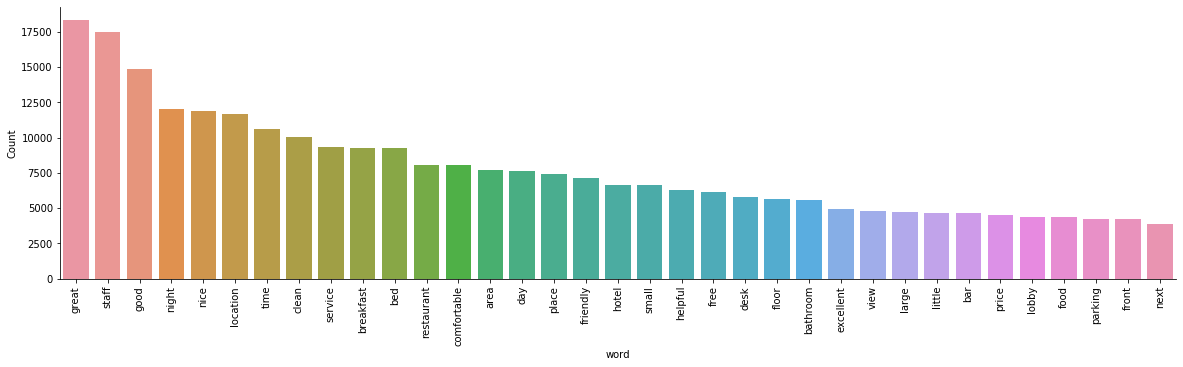

In [54]:
happy_description_detokenized = []
for i in range(len(happy_description_lemmatized)):
    happy_description_detokenized.append(' '.join(happy_description_lemmatized[i]))

happy_reviews['reviews'] = happy_description_detokenized

freq_words(happy_reviews['reviews'], 35)

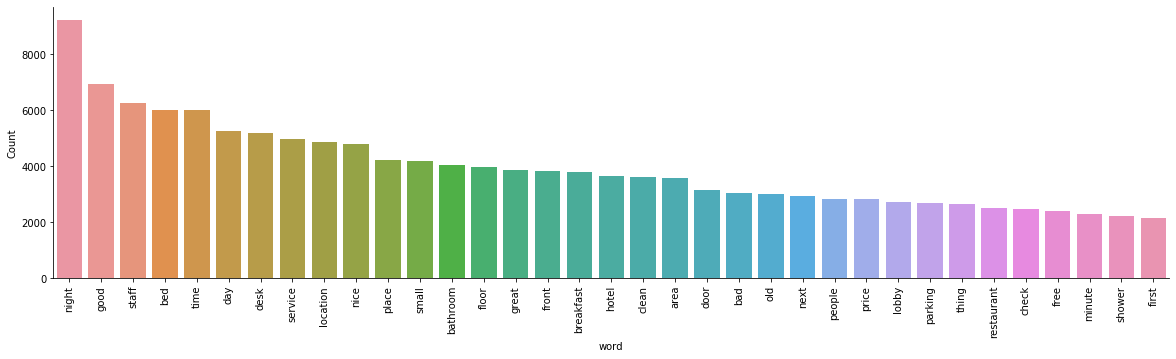

In [55]:
not_happy_description_detokenized = []
for i in range(len(not_happy_description_lemmatized)):
    not_happy_description_detokenized.append(' '.join(not_happy_description_lemmatized[i]))

not_happy_reviews['reviews'] = not_happy_description_detokenized

freq_words(not_happy_reviews['reviews'], 35)

### Build an LDA model and find topics in the happy and not-happy reviews

### Create a term dictionary of the corpus, where every unique term is assigned an index

In [56]:
happy_dictionary = corpora.Dictionary(happy_description_lemmatized)
not_happy_dictionary = corpora.Dictionary(not_happy_description_lemmatized)

### Convert the list of reviews (happy_description_lemmatized) into a Document Term Matrix using the dictionary

In [57]:
happy_doc_term_matrix = [happy_dictionary.doc2bow(rev) for rev in happy_description_lemmatized]
not_happy_doc_term_matrix = [not_happy_dictionary.doc2bow(rev) for rev in not_happy_description_lemmatized]

### Create LDA model using gensim library

In [94]:
# Creating the object for LDA model using gensim library
happy_LDA = gensim.models.ldamodel.LdaModel

# Build LDA model, previous exploratory data analysis suggested 7 is a good number for topics
happy_lda_model = happy_LDA(corpus=happy_doc_term_matrix, id2word=happy_dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

### Print out the list of topics (defined by words with high weight in this topic) for happy and not-happy reviews

In [96]:
happy_lda_model.print_topics()

[(0,
  '0.032*"service" + 0.031*"business" + 0.029*"center" + 0.029*"nice" + 0.029*"restaurant" + 0.028*"good" + 0.026*"food" + 0.025*"pool" + 0.019*"conference" + 0.018*"property"'),
 (1,
  '0.020*"night" + 0.016*"breakfast" + 0.016*"day" + 0.016*"free" + 0.012*"desk" + 0.011*"front" + 0.010*"time" + 0.010*"check" + 0.009*"good" + 0.009*"parking"'),
 (2,
  '0.039*"bathroom" + 0.038*"bed" + 0.025*"shower" + 0.023*"small" + 0.021*"nice" + 0.020*"large" + 0.017*"area" + 0.016*"comfortable" + 0.013*"floor" + 0.012*"bedroom"'),
 (3,
  '0.094*"pool" + 0.057*"kid" + 0.051*"family" + 0.030*"child" + 0.020*"hot" + 0.018*"suite" + 0.017*"old" + 0.015*"adult" + 0.015*"outdoor" + 0.014*"tub"'),
 (4,
  '0.020*"bar" + 0.017*"service" + 0.017*"view" + 0.015*"beautiful" + 0.015*"wine" + 0.011*"lobby" + 0.011*"hotel" + 0.010*"amazing" + 0.009*"evening" + 0.009*"place"'),
 (5,
  '0.037*"great" + 0.027*"location" + 0.026*"staff" + 0.025*"good" + 0.019*"clean" + 0.015*"nice" + 0.015*"night" + 0.015*"rest

In [97]:
# Creating the object for LDA model using gensim library
not_happy_LDA = gensim.models.ldamodel.LdaModel

# Build LDA model, previous analysis suggests 7 is a good number for topics
not_happy_lda_model = not_happy_LDA(corpus=not_happy_doc_term_matrix, id2word=not_happy_dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [98]:
not_happy_lda_model.print_topics()

[(0,
  '0.026*"good" + 0.023*"location" + 0.019*"night" + 0.018*"staff" + 0.017*"nice" + 0.017*"great" + 0.014*"small" + 0.013*"clean" + 0.013*"area" + 0.013*"price"'),
 (1,
  '0.032*"bed" + 0.022*"bathroom" + 0.017*"shower" + 0.017*"night" + 0.016*"floor" + 0.013*"old" + 0.013*"dirty" + 0.012*"door" + 0.012*"place" + 0.011*"towel"'),
 (2,
  '0.030*"bar" + 0.011*"lobby" + 0.010*"view" + 0.009*"guest" + 0.009*"small" + 0.008*"dark" + 0.008*"hotel" + 0.008*"large" + 0.006*"bedroom" + 0.006*"lounge"'),
 (3,
  '0.032*"breakfast" + 0.020*"coffee" + 0.016*"free" + 0.016*"water" + 0.016*"pool" + 0.014*"service" + 0.014*"day" + 0.013*"restaurant" + 0.012*"food" + 0.011*"good"'),
 (4,
  '0.017*"description" + 0.012*"crew" + 0.010*"relative" + 0.010*"dime" + 0.009*"nickel" + 0.008*"billing" + 0.008*"trade" + 0.008*"few" + 0.007*"signature" + 0.007*"push"'),
 (5,
  '0.062*"noise" + 0.044*"door" + 0.037*"night" + 0.035*"loud" + 0.029*"wall" + 0.024*"sleep" + 0.021*"construction" + 0.019*"thin" + 0

### Visualize the topics using the pyLDAvis package

In [99]:
# Visualize the topics for the happy reviews
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(happy_lda_model, happy_doc_term_matrix, happy_dictionary)
vis


/home/akira/anaconda3/envs/unsupervisedLearning/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.174933 -0.006680       1        1  34.669533
1     -0.152068 -0.083867       2        1  24.562828
6     -0.125874  0.138740       3        1  12.738660
2     -0.023954 -0.286486       4        1  11.324106
4     -0.056250  0.106795       5        1   9.086828
0      0.128686  0.183130       6        1   4.911589
3      0.404392 -0.051633       7        1   2.706457, topic_info=    Category          Freq      Term         Total  loglift  logprob
69   Default  16955.000000     staff  16955.000000  30.0000  30.0000
8    Default  18260.000000     great  18260.000000  29.0000  29.0000
388  Default   3705.000000      pool   3705.000000  28.0000  28.0000
314  Default   5534.000000  bathroom   5534.000000  27.0000  27.0000
13   Default   9200.000000   service   9200.000000  26.0000  26.0000
..       ...           ...       ...           ...      ...      ...
97    Topic7    151.400177     world    593.172241   2.2440  -5.1669
205   Topic7    276.567902      area   7846.336426   0.2642  -4.5643
216   Topic7    168.341904     water   2419.843750   0.9441  -5.0608
485   Topic7    158.737747  property   1832.043213   1.1636  -5.1195
556   Topic7    146.636063      full   1673.724731   1.1747  -5.1988

[494 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
845       3  0.993793  accommodate
835       1  0.463026     activity
835       5  0.134528     activity
835       7  0.400455     activity
889       7  0.997172        adult
...     ...       ...          ...
779       7  0.091492         year
613       2  0.176911        young
613       3  0.220335        young
613       5  0.136704        young
613       7  0.466402        young

[798 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 3, 5, 1, 4])

In [100]:
# Visualize the topics for the not-happy reviews
pyLDAvis.enable_notebook()
vis_not_happy = pyLDAvis.gensim.prepare(not_happy_lda_model, not_happy_doc_term_matrix, not_happy_dictionary)
vis_not_happy


/home/akira/anaconda3/envs/unsupervisedLearning/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.203043 -0.019316       1        1  34.665173
6      0.170344 -0.044803       2        1  24.976389
1      0.130510 -0.122958       3        1  17.816853
3      0.119141  0.127571       4        1  12.737806
2     -0.055434  0.178037       5        1   5.968918
5     -0.254206 -0.251305       6        1   3.143385
4     -0.313399  0.132775       7        1   0.691478, topic_info=     Category         Freq              Term        Total  loglift  logprob
111   Default  8957.000000             night  8957.000000  30.0000  30.0000
23    Default  3064.000000              door  3064.000000  29.0000  29.0000
201   Default  1782.000000             noise  1782.000000  28.0000  28.0000
0     Default  3748.000000         breakfast  3748.000000  27.0000  27.0000
12    Default  5870.000000               bed  5870.000000  26.0000  26.0000
...       ...          ...               ...          ...      ...      ...
6442   Topic7    15.209758            chaise    16.048346   4.9204  -5.5629
9102   Topic7    14.898968        jackhammer    15.738434   4.9193  -5.5836
6712   Topic7    14.880521        subsequent    15.719303   4.9193  -5.5848
453    Topic7    25.424164  intercontinental    53.276428   4.2343  -5.0492
3832   Topic7    15.060937          goodness    77.525505   3.3356  -5.5728

[462 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
148       1  0.435215   access
148       2  0.038835   access
148       4  0.526275   access
1063      2  0.985999  address
612       3  0.784336      air
...     ...       ...      ...
249       6  0.138081   window
611       4  0.371900     wine
611       5  0.627380     wine
863       4  0.992576   winter
2697      1  0.985933     wise

[740 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 2, 4, 3, 6, 5])

### Check each review and find which topic it belongs to (a list of probability that each topic exists in the review)

In [101]:
#Score for each review regarding the topic.

happy_review_topic_score = []
for i in range(len(happy_doc_term_matrix)):
    top_topics = happy_lda_model.get_document_topics(happy_doc_term_matrix[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(7)]
    happy_review_topic_score.append(topic_vec)
    


In [102]:
#Score for each review regarding the topic.
#for not_happy reviews

not_happy_review_topic_score = []
for i in range(len(not_happy_doc_term_matrix)):
    top_topics = not_happy_lda_model.get_document_topics(not_happy_doc_term_matrix[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(7)]
    not_happy_review_topic_score.append(topic_vec)
    


### Check some reviews to confirm the categorization

In [103]:
happy_review_topic_score[20]

[0.010227567,
 0.30919808,
 0.010221432,
 0.09997543,
 0.010217502,
 0.01022818,
 0.5499318]

In [104]:
happy_reviews.loc[20,'Description']

'Booked rooms check they upgraded all rooms suites The front desk staff was wonderful made feel great Didn use the pool can write about Right across the road from Texas Roadhouse The breakfast had scrambled eggs biscuits gravy waffles Will stay there again'

### The above review was categorized as a mixture of the last topic (talks about good staff and service) and the 2nd topic (good breakfast). Description seems to match the topic

In [105]:
happy_review_topic_score[31]

[0.0071621146,
 0.81301296,
 0.0071554077,
 0.06661236,
 0.007153906,
 0.0917372,
 0.0071660485]

In [106]:
happy_reviews.loc[31,'Description']

'agree not fancy But everything needed Breakfast pool hot tub were nice shuttle airport later check out time did have noise issue which was tough sleep through been awhile forget was noisy door nearby noisy guests complained management through later email and their credit they comp MORE than the amount had requested would return'

### The above review was categorized as belonging to the 2nd topic (good breakfast). Description match the topic

### The first topic for the "not-happy reviews" seems positive. Check the reviews to confirm

### Find the reviews that matches the first topic well (define >0.85)

In [146]:
topic1_review=[]

for i in range(len(not_happy_review_topic_score)):
    all_scores=not_happy_review_topic_score[i]
    if all_scores[0]>0.85:
        topic1_review.append(i)
        

In [148]:
not_happy_reviews.loc[topic1_review[0],'Description']

'traveling with group escorted bus trip and the hotel was selected the tour operator can comment price value for money The room had was the top floor overlooking the parks didn have any problem with street noise others have commented the rooms are bit tired but the huge king size bed was comfy and everything was clean Our tour guide must have let the hotel know that was birthday and there was lovey card and bowl fruit the room when arrived The hotel was pretty busy must popular stop for bus tours the staff were pleasant but obviously rushed Prices the site restaurant looked okay was easy walk for everything were interested Willis Tower start Route Buckingham Fountain but dont mind walking'

In [149]:
not_happy_reviews.loc[topic1_review[1],'Description']

'The hotel pleasant but little dated and the bed was the most uncomfortable ever time for renovation guys'

In [150]:
not_happy_reviews.loc[topic1_review[2],'Description']

'husband and went business conference and stayed here travel for job about the time and stay hotels all the time would have say that they have some the best customer service have ever seen and picky think the extras add like the valet and the food bar very expensive The rooms are very clean with modern furnishings but the building really old and seems dated Overall would say that comfortable just ugly the inside Yes there train station nearby and you can hear from the rooms did not bother'

In [151]:
not_happy_reviews.loc[topic1_review[3],'Description']

'Based the other reviews read this property expectations for this property were pretty high Don get wrong for Hampton this nice place but stayed WAY nicer Hampton the past room was nice size and cleaned very nicely every day but need update embedded grime the bathroom cracks various places etc The evening reception nice touch you are with nachos and draft beer not that there anything wrong with that The fitness facilities are DESPERATE need update and are among the worst seen lately Hilton rep you read this please please please update the fitness facilities the older Hamptons The was sketchy and dropped off several times night The area itself lacking food and shopping options There are maybe restaurants this exit all which are fast food You have drive few exits down for sit down meal and shopping any sort All that said the staff was very nice and the accomodations were acceptable'

In [152]:
not_happy_reviews.loc[topic1_review[4],'Description']

'This one those Priceline coups for those who trust Priceline whole lot more than should this must where they make their money back Even after you pay for the upgrade double bed suite the rooms are cramped walls are very thin windows are tiny and the staff well they just not friendly real four star hotel Great location but your priceline room will run you over after you pay for your upgrade your parking your internet access Then add taxes Speaking from experience you can lot better the theatre district with priceline you drop one the stars'

In [153]:
not_happy_reviews.loc[topic1_review[5],'Description']

'this very reasonable place stay price right clean and good location would say again'

In [154]:
not_happy_reviews.loc[topic1_review[6],'Description']

'Three stars generous for this Westin Rooms are small and very ugly Gym adequate best with just few treadmills you can stay the other Westin Chicago much much nicer This Westinl location convenient View from the Hancock Tower dining room across the street was lovely Should have stayed the Four Seasons block away Was only twenty dollars more Elevators were very slow Hard believe this Westin Even the bathroom was yucky'

### Looks like this topic is a mixed bag of some positive and some negative. Not enough evidence to overturn the initial assumption. Keep it as negative.

### Get the average score for each topic for each hotel. Make recommendations to each hotel based on their score in each topic (both positive and negative)

In [179]:
happy_review_topic_score=pd.DataFrame(happy_review_topic_score)
all_hotel_score_happy=np.zeros((7,10))
for n in range(10):
    hotel_score=happy_review_topic_score[happy_reviews['hotel_ID']==n+1]
    all_hotel_score_happy[:,n]=hotel_score.mean(axis=0)

In [182]:
all_hotel_score_happy=pd.DataFrame(all_hotel_score_happy)

### Plot the proportion of topics in happy reviews for each hotel: all hotels show similar trend

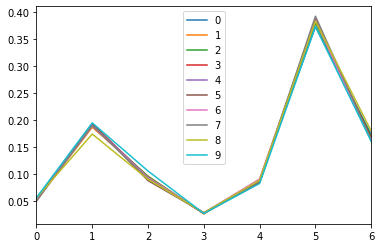

In [191]:
lines = all_hotel_score_happy.plot.line()

In [185]:
not_happy_review_topic_score=pd.DataFrame(not_happy_review_topic_score)
all_hotel_score_not_happy=np.zeros((7,10))
for n in range(10):
    hotel_score=not_happy_review_topic_score[not_happy_reviews['hotel_ID']==n+1]
    all_hotel_score_not_happy[:,n]=hotel_score.mean(axis=0)

In [193]:
all_hotel_score_not_happy=pd.DataFrame(all_hotel_score_not_happy)

### Show the proportion of topics in not-happy reviews for each hotel: all hotels show similar trend

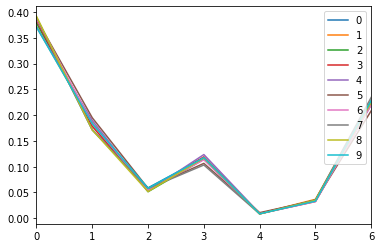

In [192]:
lines=all_hotel_score_not_happy.plot()

### Summary:

- ### For all hotels, the review from the customers are complaining about two topics: 1) a topic that is characterized by keywords: location, staff, and price and 2) a topic that is characterized by keywords: front, desk, service, and staff.

- ### General Managers at all hotels should try to improve customer service at the front desk and staff's service towards the guests because these are the most frequent complaints.

- ### For all hotels, the happy reviews are talking about topics that are characterized by keywords: front, desk, free, breakfast, staff, location, and clean.

- ### General Managers should continue to improve in these categories by improving the quality of customer service at the font desk, provide free breakfast, keep the location clean, and improve the service by their staff.